In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import datasets, neighbors, model_selection
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [72]:
###############################################################################
#               Data Generation
###############################################################################

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)

def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]

def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']

def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################

def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()

def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

###############################################################################
#               Algorithms and functions
###############################################################################

class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))

class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))

### Génération artificielle de données

Question 1-2

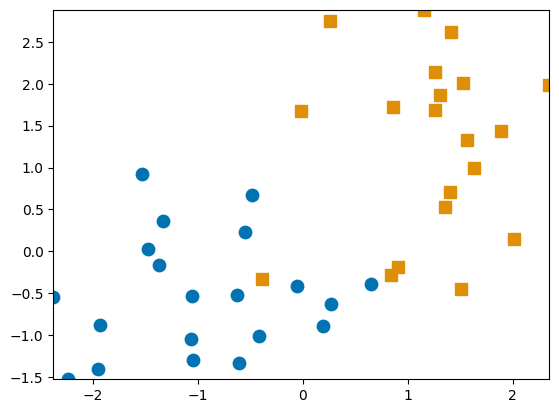

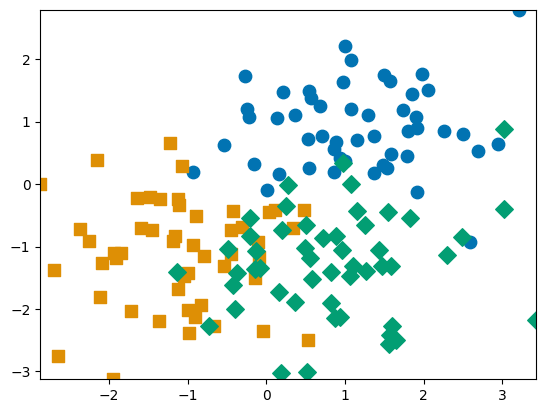

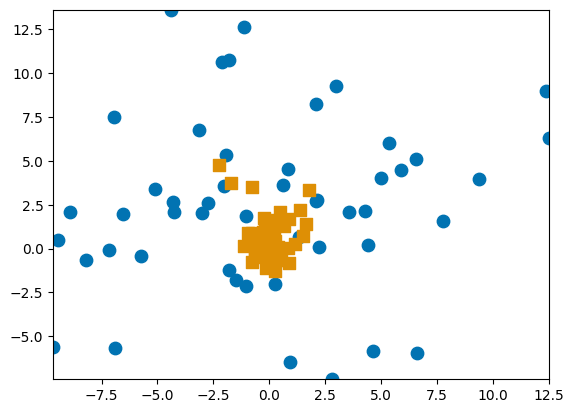

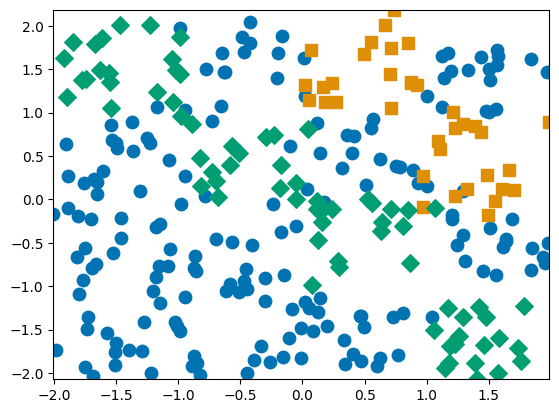

In [61]:
X1, y1 = rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],sigmas2=[0.9, 0.9])
# Renvoie les X et y (loi de gauss) (deux gaussiennnes)=> y correspond aux labels
plot_2d(X1, y1)
plt.show()

X2, y2 = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])
# Renvoie les X et y (loi de gauss) (renvoie trois gaussienne) => y correspond au labels
plot_2d(X2, y2)
plt.show()

X3, y3 = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)
# Renvoie les X et y (loi rand clown)(renvoie un sourire de clown) => y correspond au labels
plot_2d(X3, y3)
plt.show()

X4, y4 = rand_checkers(n1=150, n2=150, sigma=0.1)
# Renvoie les X et y (loi noisy checkers) (renvoie un damier) => y correspond au labels
plot_2d(X4, y4)
plt.show()



Question 3

L'adaptation de l'algorithme des k-plus proches voisins (k-NN) à la régression se fait en remplaçant la décision de classe majoritaire (utilisée en classification) par le calcul de la moyenne des valeurs des k plus proches voisins. Pour une nouvelle observation x, l'algorithme identifie ses k voisins les plus proches dans l'ensemble d'apprentissage et prédit la valeur de x comme étant la moyenne des valeurs de ces voisins. 

### Approche formelle

Question 4

In [4]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=1):
        self.k = k
    
    def fit(self, X, y): #train
        self.X_train = X
        self.y_train = y
    
    def predict(self, X): #test
        predictions = []
        for x in X:
            # Calculer les distances entre x et tous les exemples dans l'ensemble d'entraînement
            distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
            # Trier par distance et retourner les indices des premiers 'k' voisins
            k_indices = np.argsort(distances)[:self.k]
            # Extraire les étiquettes des 'k' voisins les plus proches
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            # Retourner l'étiquette la plus courante parmi les 'k' voisins
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])
        return np.array(predictions)

In [5]:
X_train, y_train = X2[::2], y2[::2]  # indices pairs
X_test, y_test = X2[1::2], y2[1::2]  # indices impairs

knn = KNNClassifier(k=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)


In [6]:
# Utilisation de l'implémentation de scikit-learn
knn_sklearn = KNeighborsClassifier(n_neighbors=3)
knn_sklearn.fit(X_train, y_train)
predictions_sklearn = knn_sklearn.predict(X_test)


In [7]:
# Évaluation
accuracy_custom = accuracy_score(y_test, predictions)
accuracy_sklearn = accuracy_score(y_test, predictions_sklearn)

print(f"Accuracy de l'implémentation créee KNN: {accuracy_custom}")
print(f"Accuracy de l'implémentation scikit-learn KNN: {accuracy_sklearn}")


Accuracy de l'implémentation créee KNN: 0.5866666666666667
Accuracy de l'implémentation scikit-learn KNN: 0.5733333333333334


Question 5

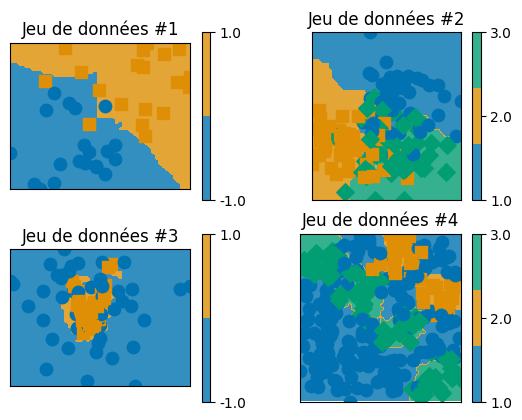

In [8]:
datasets = [(X1, y1), (X2, y2), (X3, y3), (X4, y4)]
k = 5

for i, (X, y) in enumerate(datasets, start=1):
    # Création et entraînement du modèle k-NN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    plt.subplot(2, 2, i)
    frontiere_new(lambda x: knn.predict(x.reshape(1, -1)), X, y)
    plt.title(f"Jeu de données #{i}")

plt.show()

Question 6

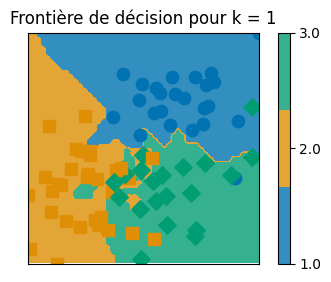

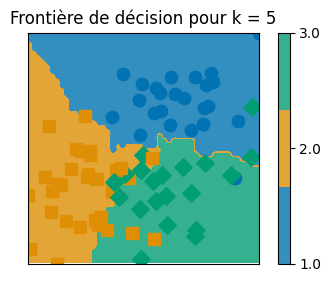

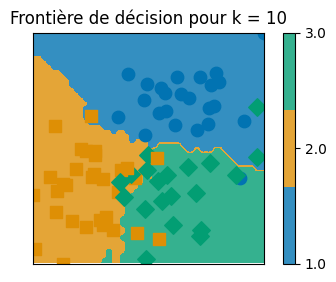

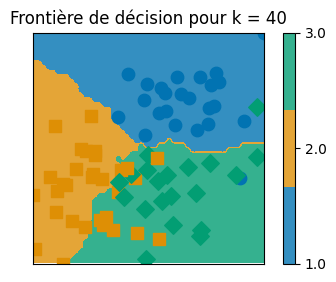

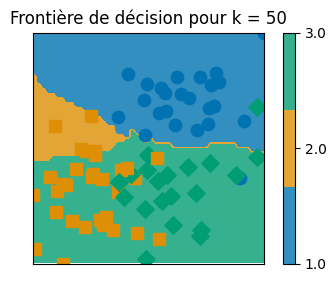

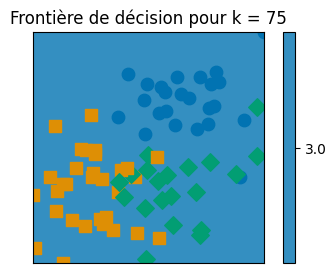

In [95]:
X_train = X2[::2]
y_train = y2[::2]
X_test = X2[1::2]
y_test = y2[1::2]

n = len(X_train)
ks = [1, 5, 10, 40, 50, n]

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    plt.figure(figsize=(5, 3))
    frontiere_new(lambda x: knn.predict(x.reshape(1, -1)), X_test, y_test)
    plt.title(f"Frontière de décision pour k = {k}")
    plt.show()


Pour k=1 : La frontière de décision est très irrégulière et complexe. Cela est typique d'un modèle qui suradapte les données d'entraînement. Chaque point d'entraînement a une grande influence sur la décision, ce qui peut conduire à de bonnes performances sur les données d'entraînement, mais souvent à de mauvaises performances sur de nouvelles données en raison d'un surapprentissage.

Pour k=75 : La frontière de décision est beaucoup plus simple car il n'y a qu'un seul cluster. Cependant, cela a conduit à un sous-apprentissage.

Question 7

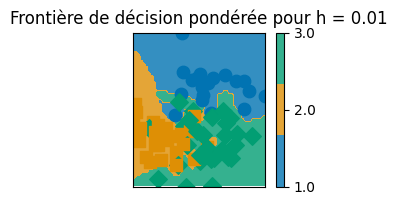

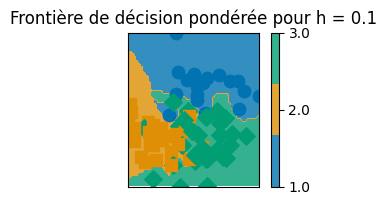

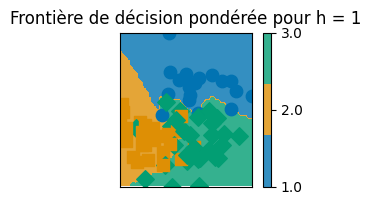

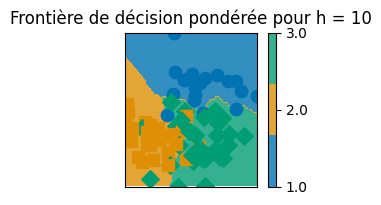

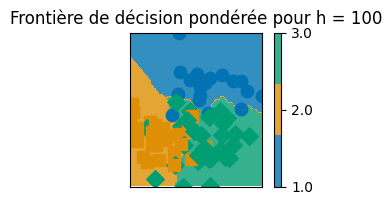

In [10]:

X_train = X2[::2]
y_train = y2[::2]
X_test = X2[1::2]
y_test = y2[1::2]

k = 7
h_values = [10**j for j in range(-2,3)]


for h in h_values:
    def _weight_func(dist):
        return np.exp(-dist**2/h)
    knn = KNeighborsClassifier(n_neighbors=k, weights=_weight_func)
    knn.fit(X_train, y_train)

    plt.figure(figsize=(3, 2))
    frontiere_new(lambda x: knn.predict(x.reshape(1, -1)), X_train, y_train)
    plt.title(f"Frontière de décision pondérée pour h = {h}")
    plt.show()


Dans ce cas, plus la valeur de h est élevé plus les frontières sont simples

Question 8

In [11]:
X_train = X2[::2]
y_train = y2[::2]
X_test = X2[1::2]
y_test = y2[1::2]

# Entraînement du modèle k-NN avec k=1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Prédiction sur l'ensemble d'apprentissage
train_predictions = knn.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_error_rate = 1 - train_accuracy

# Prédiction sur l'ensemble de test
test_predictions = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_error_rate = 1 - test_accuracy

print(f"Taux d'erreur sur l'ensemble d'apprentissage : {train_error_rate}")
print(f"Taux d'erreur sur l'ensemble de test : {test_error_rate}")

Taux d'erreur sur l'ensemble d'apprentissage : 0.0
Taux d'erreur sur l'ensemble de test : 0.42666666666666664


Pour les données d'apprentissage, étant donné que k = 1, le classifieur va toujours prédire la classe de l'unique plus proche voisin, qui est l'observation elle-même, donc le taux d'erreur sur l'ensemble d'apprentissage sera toujours de 0. 

Pour les données de test, le taux d'erreur est de 43 % sur l'ensemble de test ce qui est assez élevé et indique que le modèle ne généralise pas bien sur les données qu'il n'a pas vues. C'est un signe de surapprentissage : le modèle est tellement ajusté aux données d'entraînement qu'il échoue à prédire correctement les nouvelles données.

Question 9

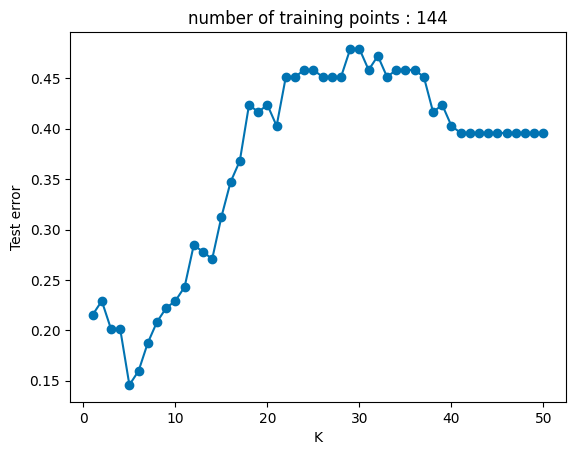

In [12]:
X_train = X4[::2]
y_train = y4[::2]
X_test = X4[1::2]
y_test = y4[1::2]

error_curve = ErrorCurve(k_range=list(range(1, 51)))
error_curve.fit_curve(X_train, y_train, X_test, y_test)
error_curve.plot()

1. **Baisse rapide du taux d'erreur :** Au début, lorsque k augmente de 1 à environ 5, le taux d'erreur diminue rapidement. Cela suggère que prendre en compte plus de voisins aide à obtenir de meilleures prédictions, probablement en réduisant l'impact du bruit et des outliers dans les données d'apprentissage.

2. **Augmentation et fluctuations du taux d'erreur :** Entre k = 5 et k environ 30, le taux d'erreur augmente et fluctue. Cela peut indiquer que pour ces valeurs de k, l'algorithme commence à considérer des voisins qui ne sont pas pertinents pour la prédiction, introduisant ainsi des erreurs.

3. **Stabilisation du taux d'erreur :** Au-delà de k = 40, le taux d'erreur semble se stabiliser avec moins de fluctuations, bien qu'il reste à un niveau relativement élevé par rapport au minimum observé pour les petites valeurs de k. Cela peut être un signe que l'algorithme est en train de généraliser et ne s'adapte plus autant aux particularités des données d'entraînement.

QUESTION 10

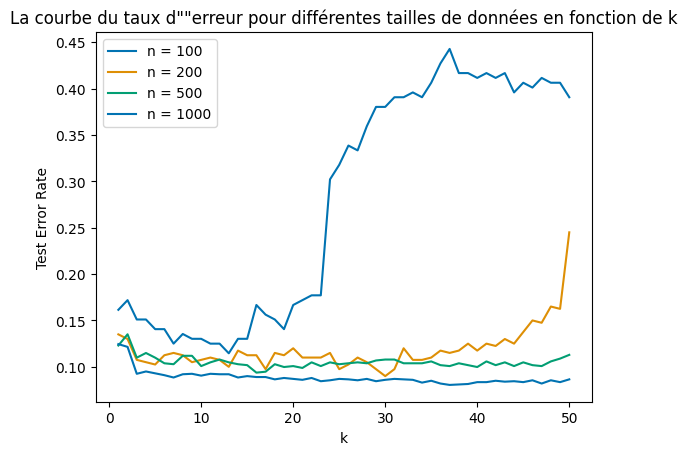

La meilleure valeur de k pour n = 100 est k = 13
La meilleure valeur de k pour n = 200 est k = 30
La meilleure valeur de k pour n = 500 est k = 16
La meilleure valeur de k pour n = 1000 est k = 37


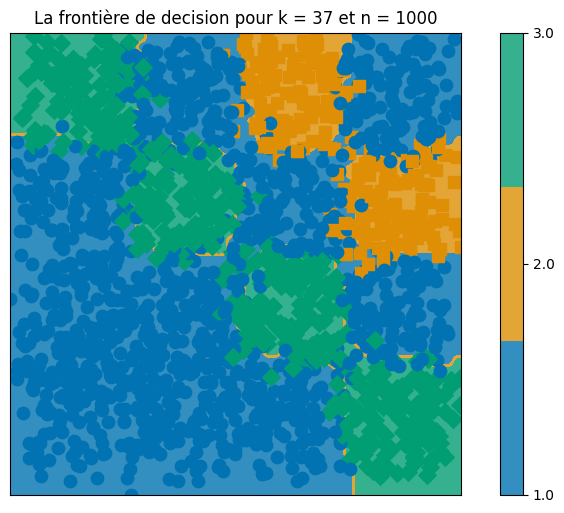

In [13]:
n_samples = [100, 200, 500, 1000]
k_values = range(1, 51)
best_k_by_n = {}


for n in n_samples:
    X4_train, y4_train = rand_checkers(n1=n, n2=n, sigma=0.1)
    X4_test, y4_test = rand_checkers(n1=n, n2=n, sigma=0.1)

    error_rates = []
    best_k = 1
    min_error_rate = 1

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X4_train, y4_train)

        predictions = knn.predict(X4_test)
        
        error_rate = 1 - accuracy_score(y4_test, predictions)
        error_rates.append(error_rate)

        if error_rate < min_error_rate:
            min_error_rate = error_rate
            best_k = k

    best_k_by_n[n] = best_k

    plt.plot(k_values, error_rates, label=f'n = {n}')

plt.xlabel('k')
plt.ylabel('Test Error Rate')
plt.title('La courbe du taux d"''"erreur pour différentes tailles de données en fonction de k')
plt.legend()
plt.show()

for n, best_k in best_k_by_n.items():
    print(f'La meilleure valeur de k pour n = {n} est k = {best_k}')


if 1000 in n_samples:
    best_k = best_k_by_n[1000]
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X4_train, y4_train)

    plt.figure(figsize=(10, 6))
    frontiere_new(lambda x: knn.predict(x.reshape(1, -1)), X4_train, y4_train)
    plt.title(f'La frontière de decision pour k = {best_k} et n = 1000')
    plt.show()



Les meilleurs k n'ont pas les mêmes valeurs pour les différents datasets

Question 11

**Avantages du k-NN :**

1. **Simplicité :** Le k-NN est intuitivement simple et facile à implémenter. Il n'y a pas besoin d'entraînement ou d'optimisation de modèle, ce qui le rend rapide à démarrer en termes de prédiction une fois que vous avez les données.

2. **Non-paramétrique :** Comme il ne suppose pas de forme particulière pour la distribution sous-jacente des données, il est utile dans les situations où la relation entre les attributs est complexe et ne peut pas être bien capturée par des modèles paramétriques.

3. **Adaptatif :** Il peut s'adapter à mesure que vous collectez de nouvelles données, en intégrant simplement les données dans l'ensemble de données existant sans nécessiter de réentraînement.

4. **Raisonnablement bon pour des bases de données de petite taille :** Il peut être très efficace si l'ensemble de données est suffisamment petit.

**Inconvénients du k-NN :**

1. **Coût de calcul élevé :** Pour chaque prédiction, k-NN doit calculer la distance de l'élément à classer à tous les éléments de l'ensemble d'entraînement, ce qui peut être très coûteux en temps de calcul pour de grands ensembles de données.

2. **Mauvais passage à l'échelle :** Le coût de calcul élevé devient problématique à mesure que la taille des données augmente, rendant l'algorithme moins pratique pour les grands ensembles de données (big data).

3. **Sensibilité au déséquilibre des classes et au bruit :** k-NN peut être sensible aux données de formation bruyantes ou aux ensembles de données où certaines classes sont sur-représentées.

4. **Choix de k et de la métrique de distance :** Le choix du nombre de voisins k et de la métrique de distance peut avoir un grand impact sur la performance du modèle, et ces choix ne sont pas toujours évidents.

5. **Stockage de données :** Comme il nécessite la conservation de tout l'ensemble de données d'entraînement pour la prédiction, il peut être coûteux en termes de stockage.

6. **Interprétabilité :** Bien que l'algorithme lui-même soit simple, les raisons sous-jacentes pour lesquelles une prédiction est faite ne sont pas toujours claires, surtout en comparaison avec des modèles plus explicites comme les arbres de décision.

Question 12

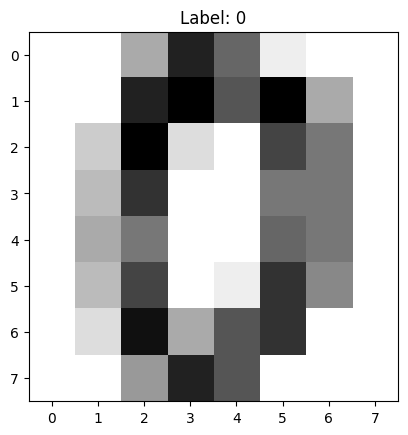

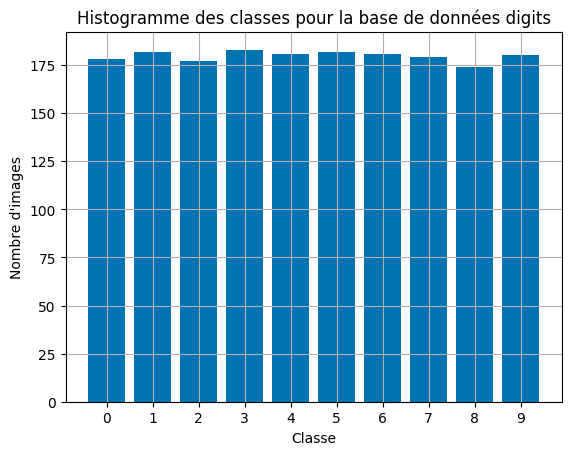

In [14]:
Digits = datasets.load_digits()

plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title(f"Label: {digits.target[0]}")
plt.show()

plt.hist(digits.target, bins=np.arange(11)-0.5, rwidth=0.8)
plt.title("Histogramme des classes pour la base de données digits")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.grid(True)
plt.xticks(range(10))
plt.show()


Nature des Données :

Type de Données : Images en niveaux de gris de chiffres manuscrits.
Classes : Les chiffres de 0 à 9, donc 10 classes au total.
Usage : Utilisé pour des tâches de classification où l'objectif est de reconnaître quel chiffre est représenté par une image.
Format des Données :

Images : Chaque image est un tableau de 8x8 pixels. Chaque pixel représente une intensité en niveaux de gris, avec des valeurs allant de 0 à 16 (0 étant blanc et 16 étant noir).
Ensemble de Données : digits.data est un array où chaque ligne correspond à une image aplatie (c'est-à-dire un vecteur de 64 valeurs).
Labels : digits.target contient les étiquettes (labels), qui sont les chiffres réels que chaque image représente.

In [15]:
# Couper l'échantillon en deux parties de même taille
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.5, random_state=0)

# Appliquer la méthode k-NN aux données
k = 30  # ou toute autre valeur de k que vous souhaitez tester
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Faire des prédictions et calculer le taux d'erreur
predictions = knn.predict(X_test)
error_rate = 1 - accuracy_score(y_test, predictions)

print(f"Le taux d'erreur pour k = {k} est de : {error_rate}")


Le taux d'erreur pour k = 30 est de : 0.05450500556173521


Question 13

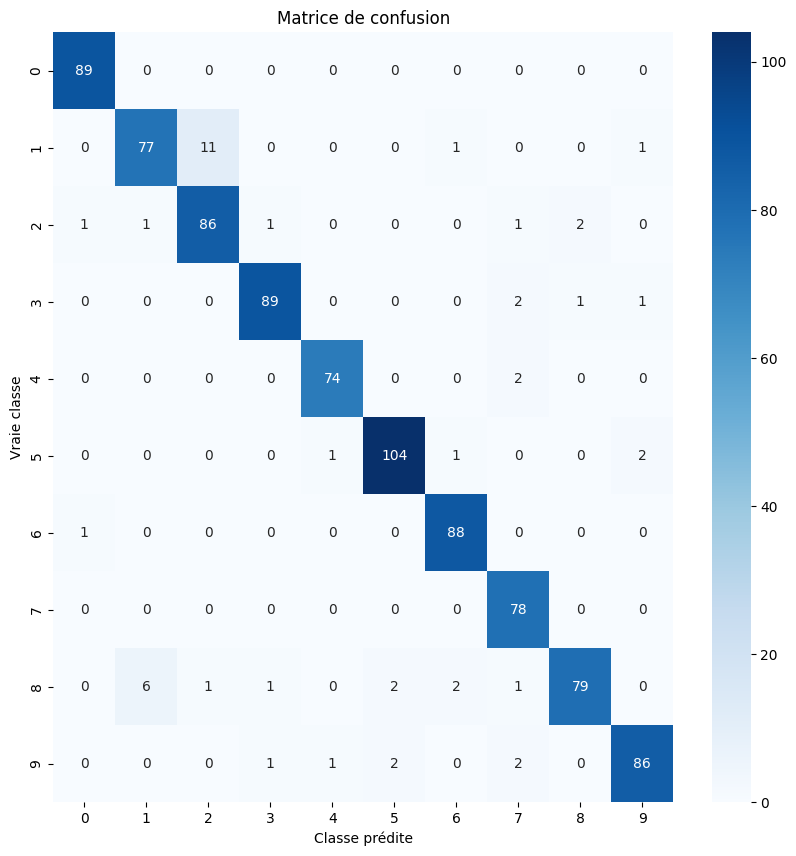

In [16]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()


Question 14

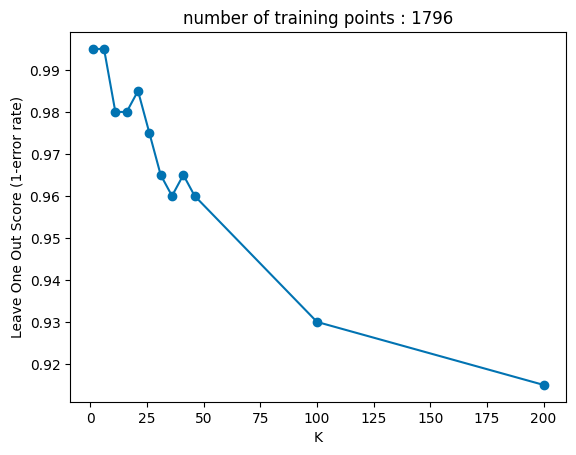

In [17]:
digits = datasets.load_digits()
X, y = digits.data, digits.target

k_values = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
loo_curve = LOOCurve(k_range=k_values)

loo_curve.fit_curve(X, y)

loo_curve.plot()
plt.show()


#### Aspect théorique

Question 15

\begin{align*}
P(Y = +1 | X = x) &= \frac{P((X = x) \cap (Y = +1))}{P(X = x)} \\
&= \frac{P(X = x | Y = +1) \cdot P(Y = +1)}{P(X = x | Y = +1) \cdot P(Y = +1) + P(X = x | Y = -1) \cdot P(Y = -1)} \\
&= \frac{f_+(x) \cdot \pi_+}{f_+(x) \cdot \pi_+ + f_-(x) \cdot (1 - \pi_+)}
\end{align*}


\begin{align*}
P(Y = -1 | X = x) &= \frac{P((X = x) \cap (Y = -1))}{P(X = x)} \\
&= \frac{P(X = x | Y = -1) \cdot P(Y = -1)}{P(X = x | Y = +1) \cdot P(Y = +1) + P(X = x | Y = -1) \cdot P(Y = -1)} \\
&= \frac{f_-(x) \cdot (1 - \pi_+)}{f_+(x) \cdot \pi_+ + f_-(x) \cdot (1 - \pi_+)}
\end{align*}


Question 16

\begin{align*}
\log \left( \frac{P(Y = +1 | X = x)}{P(Y = -1 | X = x)} \right) &= \log \left( \frac{f_+(x) \cdot \pi_+}{f_-(x) \cdot (1 - \pi_+)} \right) \\
&= \log(f_+(x)) + \log(\pi_+) - \log(f_-(x)) - \log(1 - \pi_+) \\
&= \log \left( \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}} e^{-\frac{1}{2}(x - \mu_+)^T \Sigma^{-1} (x - \mu_+)} \right) + \log(\pi_+) \\
&\quad - \log \left( \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}} e^{-\frac{1}{2}(x - \mu_-)^T \Sigma^{-1} (x - \mu_-)} \right) - \log(1 - \pi_+) \\
&= -\frac{1}{2}(x - \mu_+)^T \Sigma^{-1} (x - \mu_+) + \log(\pi_+) \\
&\quad +\frac{1}{2}(x - \mu_-)^T \Sigma^{-1} (x - \mu_-) - \log(1 - \pi_+) \\
&= x^T \Sigma^{-1} (\mu_+ - \mu_-) - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + \log \left( \frac{\pi_+}{1 - \pi_+} \right)
\end{align*}


Question 17


Soit le log-ratio des probabilités a posteriori:
$
\log \left( \frac{P(Y = +1 | X = x)}{P(Y = -1 | X = x)} \right)
$

Nous classons \( x \) dans la classe +1 si:
$
\log \left( \frac{P(Y = +1 | X = x)}{P(Y = -1 | X = x)} \right) > 0
$

Ce qui équivaut à:
$
P(Y = +1 | X = x) > P(Y = -1 | X = x)
$

Inversement, nous classons \( x \) dans la classe -1 si:
$
\log \left( \frac{P(Y = +1 | X = x)}{P(Y = -1 | X = x)} \right) \leq 0
$

Ce qui équivaut à:
$
P(Y = +1 | X = x) \leq P(Y = -1 | X = x)
$

Cela découle directement du fait que le logarithme est une fonction strictement croissante, donc le log-ratio est positif si et seulement si le numérateur est supérieur au dénominateur.

On retrouve donc l'équation donnée :


\begin{equation}
\hat{y} = \begin{cases} 
1 & \text{si } x^T\Sigma^{-1}(\mu_+ - \mu_-) > \frac{1}{2}\mu_+^T\Sigma^{-1}\mu_+ - \frac{1}{2}\mu_-^T\Sigma^{-1}\mu_- + \log\left(\frac{1 - \pi_+}{\pi_+}\right) \\
-1 & \text{sinon}
\end{cases}
\end{equation}


#### Mise en oeuvre

Question 18

In [44]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        # Séparer les données en classes
        self.classes_, counts = np.unique(y, return_counts=True)
        self.priors_ = counts / counts.sum()

        # Calcul des moyennes et de la matrice de covariance
        self.means_ = [X[y == cls].mean(axis=0) for cls in self.classes_]
        self.cov_ = sum([np.cov(X[y == cls].T) * (len(X[y == cls]) - 1) for cls in self.classes_]) / (len(X) - len(self.classes_))
        self.inv_cov_ = np.linalg.inv(self.cov_)

        # Calcul du vecteur de séparation linéaire
        self.coef_ = np.dot(self.inv_cov_, self.means_[1] - self.means_[0])
        self.intercept_ = -0.5 * np.dot(self.means_[1], self.inv_cov_.dot(self.means_[1])) + 0.5 * np.dot(self.means_[0], self.inv_cov_.dot(self.means_[0])) + np.log(self.priors_[1] / self.priors_[0])

        return self

    def predict(self, X):
        return (np.dot(X, self.coef_) + self.intercept_ > 0).astype(int)


Question 19

In [51]:

# Création de données simulées
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, test_size=0.8, random_state=0, stratify=y)


# LDAClassifier
lda_custom = LDAClassifier()
lda_custom.fit(X_train, y_train)
predictions_custom = lda_custom.predict(X_test)

# LinearDiscriminantAnalysis
lda_sklearn = LinearDiscriminantAnalysis()
lda_sklearn.fit(X_train, y_train)
predictions_sklearn = lda_sklearn.predict(X_test)

# Taux d'erreur
error_custom = 1 - accuracy_score(y_test, predictions_custom)
error_sklearn = 1 - accuracy_score(y_test, predictions_sklearn)
coinciding_cases = np.sum(predictions_custom == predictions_sklearn)


print(f"Taux d'erreur LDAClassifier : {error_custom}")
print(f"Taux d'erreur LinearDiscriminantAnalysis : {error_sklearn}")
print(f"Nombre de coïncidences dans les prédictions : {coincidences}/100")


Taux d'erreur LDAClassifier : 0.10250000000000004
Taux d'erreur LinearDiscriminantAnalysis : 0.10250000000000004
Nombre de coïncidences dans les prédictions : 77/100


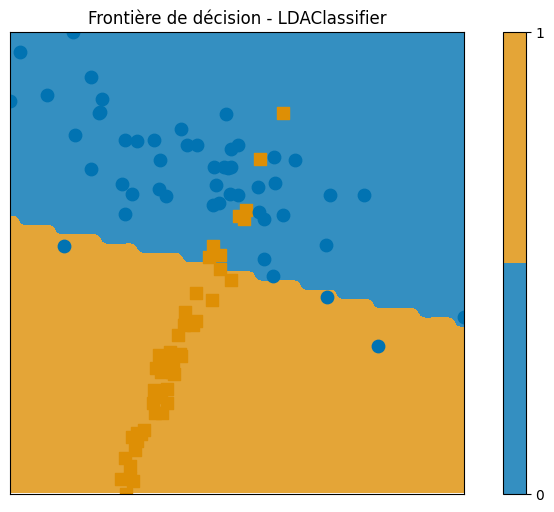

In [52]:
plt.figure(figsize=(10, 6))
frontiere_new(lambda x: lda_custom.predict(x.reshape(1, -1)), X_train, y_train)
plt.title("Frontière de décision - LDAClassifier")
plt.show()


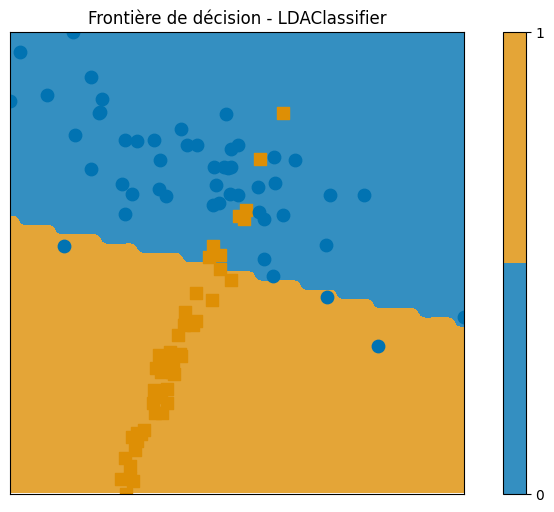

In [53]:
plt.figure(figsize=(10, 6))
frontiere_new(lambda x: lda_sklearn.predict(x.reshape(1, -1)), X_train, y_train)
plt.title("Frontière de décision - LDAClassifier")
plt.show()

Question 20

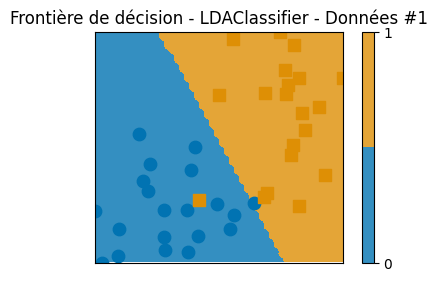

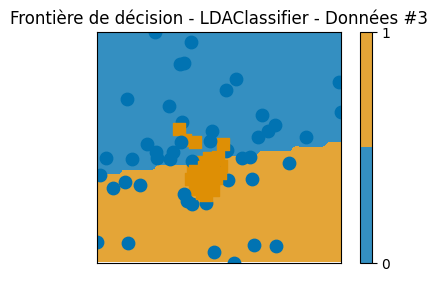

In [67]:
# LDAClassifier #1
lda_classifier_1 = LDAClassifier()
lda_classifier_1.fit(X1, y1)

plt.figure(figsize=(5, 3))
frontiere_new(lambda x: lda_classifier_1.predict(x.reshape(1, -1)), X1, y1)
plt.title("Frontière de décision - LDAClassifier - Données #1")
plt.show()

# #3
lda_classifier_3 = LDAClassifier()
lda_classifier_3.fit(X3, y3)

plt.figure(figsize=(5, 3))
frontiere_new(lambda x: lda_classifier_3.predict(x.reshape(1, -1)), X3, y3)
plt.title("Frontière de décision - LDAClassifier - Données #3")
plt.show()


Données #1 : La frontière semble être une ligne droite qui sépare assez bien les deux classes. C'est le comportement attendu de LDA lorsque les données sont relativement bien séparées et suivent une distribution gaussienne avec des covariances similaires. Cela indique que LDA est approprié pour ce type de données.


Données #3 : La frontière de décision semble moins claire, avec des régions où les classes se chevauchent. Cela peut suggérer que les données ne sont pas linéairement séparables ou que les hypothèses de LDA (en particulier, des covariances identiques) ne sont pas entièrement respectées. Dans ce cas, LDA pourrait ne pas être la méthode la plus efficace, et d'autres approches, telles que la régression logistique ou les méthodes non linéaires, pourraient être envisagées.

#### Méthode discriminative avec régression logistique

Question 21

In [84]:
# Génération de données équilibrées et déséquilibrées
X_balanced, y_balanced = rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])
X_unbalanced, y_unbalanced = rand_bi_gauss(n1=10, n2=200, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_balanced, y_balanced)
y_pred_lda_balanced = lda.predict(X_balanced)
error_lda_balanced = 1 - accuracy_score(y_balanced, y_pred_lda_balanced)

lda.fit(X_unbalanced, y_unbalanced)
y_pred_lda_unbalanced = lda.predict(X_unbalanced)
error_lda_unbalanced = 1 - accuracy_score(y_unbalanced, y_pred_lda_unbalanced)

# Régression logistique
logreg = linear_model.LogisticRegression()
logreg.fit(X_balanced, y_balanced)
y_pred_logreg_balanced = logreg.predict(X_balanced)
error_logreg_balanced = 1 - accuracy_score(y_balanced, y_pred_logreg_balanced)

logreg.fit(X_unbalanced, y_unbalanced)
y_pred_logreg_unbalanced = logreg.predict(X_unbalanced)
error_logreg_unbalanced = 1 - accuracy_score(y_unbalanced, y_pred_logreg_unbalanced)

# Taux d'erreur
print(f"Erreur LDA (équilibrée) : {error_lda_balanced}, Erreur LogReg (équilibrée) : {error_logreg_balanced}")
print(f"Erreur LDA (déséquilibrée) : {error_lda_unbalanced}, Erreur LogReg (déséquilibrée) : {error_logreg_unbalanced}")


Erreur LDA (équilibrée) : 0.06000000000000005, Erreur LogReg (équilibrée) : 0.05500000000000005
Erreur LDA (déséquilibrée) : 0.023809523809523836, Erreur LogReg (déséquilibrée) : 0.01904761904761909


Données Équilibrées : La régression logistique et la LDA ont des performances assez similaires, avec un léger avantage pour la régression logistique. Cela peut être dû à la nature des données qui, si elles sont linéairement séparables, conviennent bien aux deux méthodes.


Données Déséquilibrées : Dans le cas des classes déséquilibrées, la régression logistique semble également légèrement mieux performer que la LDA. Cela pourrait être dû au fait que la régression logistique est moins affectée par le déséquilibre des classes. La régression logistique maximise directement la probabilité conditionnelle des étiquettes étant donné les caractéristiques, ce qui peut fournir une meilleure estimation quand les classes ne sont pas également représentées.

Question 22

coef_ : Ce sont les coefficients des variables prédictives (ou caractéristiques) dans la fonction de décision. Chaque coefficient représente l'effet d'une unité de changement de la variable correspondante sur la probabilité log-odds de la variable dépendante, lorsque toutes les autres variables restent constantes. En d'autres termes, coef_ reflète l'importance de chaque caractéristique pour la classification. Pour un problème à deux classes, coef_ est un vecteur; pour un problème à plusieurs classes, c'est une matrice dont chaque ligne correspond à une classe.


intercept_ : C'est la constante, ou le terme d'interception, dans la fonction de décision. Il représente le log-odds de la variable dépendante lorsque toutes les variables prédictives sont égales à zéro. Dans la régression logistique multiclass (one-vs-rest par exemple), intercept_ est un vecteur contenant l'interception pour chaque classe.

$\log\left(\frac{p}{1 - p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$


$ p $ est la probabilité que l'observation appartienne à la classe 1.

$\beta_0 $ est l'intercept 'intercept_' du modèle.

$\beta_1, \beta_2, \ldots, \beta_n $ sont les coefficients 'coef_' du modèle correspondant aux caractéristiques $ x_1, x_2, \ldots, x_n $ de l'observation.




Question 23

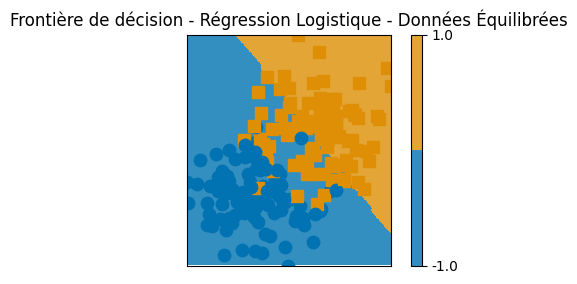

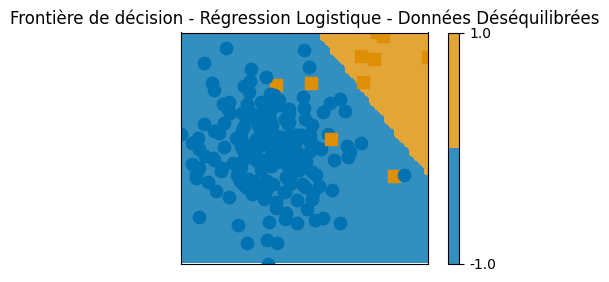

In [90]:
# Reg log Données équilibrées
plt.figure(figsize=(5, 3))
frontiere_new(lambda x: logreg.predict(x.reshape(1, -1)), X_balanced, y_balanced)
plt.title("Frontière de décision - Régression Logistique - Données Équilibrées")
plt.show()

# Reg log Données déséquilibrées
plt.figure(figsize=(5, 3))
frontiere_new(lambda x: logreg.predict(x.reshape(1, -1)), X_unbalanced, y_unbalanced)
plt.title("Frontière de décision - Régression Logistique - Données Déséquilibrées")
plt.show()


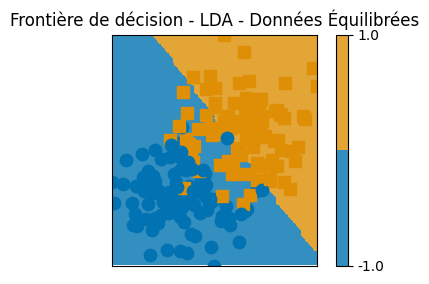

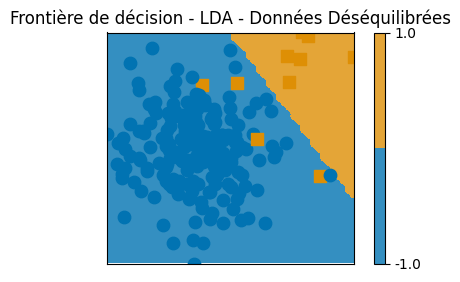

In [94]:
# LDA données équilibrées
plt.figure(figsize=(5, 3))
frontiere_new(lambda x: lda.predict(x.reshape(1, -1)), X_balanced, y_balanced)
plt.title("Frontière de décision - LDA - Données Équilibrées")
plt.show()

# LDA données déséquilibrées
plt.figure(figsize=(5, 3))
frontiere_new(lambda x: lda.predict(x.reshape(1, -1)), X_unbalanced, y_unbalanced)
plt.title("Frontière de décision - LDA - Données Déséquilibrées")
plt.show()

Question 24

In [85]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5, random_state=0)

# Régression logistique
logisticRegr = LogisticRegression(max_iter=10000)
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

# Taux d'erreur
error_rate = 1 - accuracy_score(y_test, predictions)

print(f"Taux d'erreur : {error_rate}")


Taux d'erreur : 0.04560622914349277
